## Code to predict directories of images and create dataframe with results

In [1]:
#load up the basics
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#image file issue
#https://stackoverflow.com/questions/48395076/keras-giving-oserror-image-file-is-truncated-26-bytes-not-processed
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None


#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")
    
#help w/ predict generator from: 
#https://stackoverflow.com/questions/57516673/how-to-perform-prediction-using-predict-generator-on-unlabeled-test-data-in-kera

TF version: 2.3.2
 GPU: /device:GPU:0


In [2]:
#Load up the TF model

#model path
model_path = './models/VGG16_model_7_8020split_512px_2stepFT'

# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)

In [3]:
#flow from dataframe
#https://stackoverflow.com/questions/58116359/is-there-a-simple-way-to-use-only-half-of-the-images-in-underlying-directories-u
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [4]:
# build the generator.

# here are the numbers for each storms, if we want to break those out for par. processing.
#(vs. running entire dir of all storms).
# Barry, 8900
# Delta, 9785
# Dorian, 24749
# Florence, 31434
# Gordon, 2019
# Isaias, 8938
# Laura, 24165
# Michael, 9600
# Sally, 6390
# Zeta, 8644
# Ida
# Henri
# pred_data_dir = '/data/NOAA_ERI/Florence'


#directory
pred_data_dir = '/data/NOAA_ERI'

batch_size = 32

#set Image size based on the model(RGB, so 3 channels)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

#rescale the images
pred_datagen = ImageDataGenerator(rescale =1./255.)

# Flow images in batches 
pred_generator = pred_datagen.flow_from_directory(pred_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = None,
                                                    target_size = imsize,
                                                    shuffle = False)
#reset the generator counter
pred_generator.reset()


Found 135245 images belonging to 13 classes.


In [5]:
#set number of images based on output of previous cell
numberofimages = 135245

#make the predictions
prediction = model.predict(pred_generator,
                           verbose=1,
                           steps=numberofimages/batch_size,
                           workers = 24)

4227/4226 [==============================] - 27820s 7s/step


In [6]:
#get the filenames
filenames = pred_generator.filenames

#convert the predictions to a list
PredList = prediction.tolist()

#and make a dataframe with filenames adn predictions
PredDF = pd.DataFrame({'Filename': filenames,'Prediction': PredList})

#PredDF.head()
#PredDF.dtypes

In [7]:
#remove the brackets from the prediction list
PredDF["Prediction"] = PredDF["Prediction"].str[0]

#Convert the predcit column to numeric
PredDF["Prediction"] = pd.to_numeric(PredDF["Prediction"])

#and check to see it worked
PredDF.head()

,Filename,Prediction
0,Barry/20190716a_jpgs/jpgs/C19748935.jpg,0.520629
1,Barry/20190716a_jpgs/jpgs/C19748941.jpg,0.516580
2,Barry/20190716a_jpgs/jpgs/C19748947.jpg,0.512670
3,Barry/20190716a_jpgs/jpgs/C19748953.jpg,0.532304
4,Barry/20190716a_jpgs/jpgs/C19748959.jpg,0.540272


In [8]:
#save the data

#new csv to save
newpredcsv = '../data/tables/Model7AllPreds.csv'

PredDF.to_csv(newpredcsv, index=False)

In [9]:
#read in the master DF
mdf = pd.read_csv('../data/tables/MasterDF_09102021b_R7.csv')

#rename column with pred#
PredDF = PredDF.rename({'Prediction': 'Prediction7'}, axis=1)

#merge to prediction dataframe
New_mdf = pd.merge(mdf,PredDF, on="Filename", how = "left")
New_mdf.head()

,Filename,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,archive,date,image,labeled,...,lr_lat,lr_lon,size,storm_id,ul_lat,ul_lon,ur_lat,ur_lon,Prediction6,Prediction7
0,Barry/20190716a_jpgs/jpgs/C19748935.jpg,0.093053,0.458411,0.679300,0.274590,0.021257,20190716a_jpgs,2019-07-16,C19748935.jpg,NaN,...,29.501893,-92.311318,4875221,barry,29.514684,-92.317575,29.509719,-92.306144,0.210064,0.520629
1,Barry/20190716a_jpgs/jpgs/C19748941.jpg,0.002945,0.449371,0.456580,0.237515,0.043771,20190716a_jpgs,2019-07-16,C19748941.jpg,NaN,...,29.506580,-92.308422,5842249,barry,29.518644,-92.316049,29.514679,-92.304272,0.144417,0.516580
2,Barry/20190716a_jpgs/jpgs/C19748947.jpg,0.002490,0.413135,0.469627,0.226322,0.052162,20190716a_jpgs,2019-07-16,C19748947.jpg,NaN,...,29.511428,-92.306184,6061687,barry,29.522755,-92.314927,29.519666,-92.302932,0.151956,0.512670
3,Barry/20190716a_jpgs/jpgs/C19748953.jpg,0.020509,0.361904,0.444304,0.202061,0.065795,20190716a_jpgs,2019-07-16,C19748953.jpg,NaN,...,29.516382,-92.305242,5873595,barry,29.527209,-92.314396,29.524401,-92.302525,0.156361,0.532304
4,Barry/20190716a_jpgs/jpgs/C19748959.jpg,0.043591,0.347595,0.443178,0.191845,0.061327,20190716a_jpgs,2019-07-16,C19748959.jpg,NaN,...,29.521040,-92.304028,6159050,barry,29.531420,-92.313768,29.529043,-92.301852,0.156329,0.540272


In [10]:
#new csv to save
newmdfcsv = '../data/tables/MasterDF_09162021.csv'

New_mdf.to_csv(newmdfcsv, index=False)

In [11]:
# how many washover images?
predsWash = New_mdf[New_mdf["Prediction7"] >= 0.5]
predsWash.shape

(9100, 22)

Text(0, 0.5, '% images with Washover')

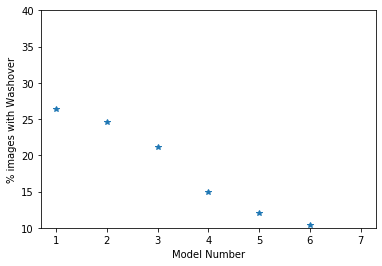

In [12]:
WashImages = np.array([35441,33092, 28394, 20025,16229,13975,9100])
WashImagesPercent= 100* (WashImages/134624)
Model =[1,2,3,4,5,6,7]


plt.plot(Model,WashImagesPercent,'*')
plt.ylim([10, 40])
plt.xlabel('Model Number')
plt.ylabel('% images with Washover')